# Using BALD to Predict for Financial Managers

This is a demonstration meant to give a sense of the questions required and the outcomes with a set of 5 or so questions. 

In [2]:
import tensorflow as tf
import gpflow
import trieste

2022-11-27 14:22:03.815549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-27 14:22:03.815570: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/156/jm0124/.local/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/home/156/jm0124/.local/lib/python3.9/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2022-11-27 14:22:35.666149: W tensorflow/stream_executor/platfor

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import copy
from trieste.acquisition.function import BayesianActiveLearningByDisagreement as BALD
from trieste.acquisition.rule import OBJECTIVE
from trieste.models.gpflow.models import VariationalGaussianProcess as VGP
from trieste.objectives.utils import mk_observer 
from trieste.models.gpflow.builders import build_vgp_classifier

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import pandas as pd

In [6]:
from sklearn import svm
from skimage import measure
from sklearn.datasets import make_blobs, make_circles

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [7]:
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.patches as mpatches

## Initial Data

We need to assertain what range of values we want to get an estimate for and get some initial points for training of the kernel.

**Question: What is your investment horizon?**

In [8]:
investmentHorizon = int(input())

 15


**Question: What is your initial capital?**

In [9]:
initialCapital = int(input())

 20000


In [10]:
largestReturn = 1.08
minimumReturn = 1.02

In [11]:
maximum = initialCapital * (largestReturn)**(investmentHorizon)
minimum = initialCapital * (minimumReturn)**(investmentHorizon)

**Initial Points for Intertemporal Prediction**

In [12]:
avgReturn = (largestReturn + minimumReturn)/2
listOfITPoints = []

for time in [round(investmentHorizon/4),round(investmentHorizon/2),round(investmentHorizon)]:
    pt = initialCapital * (avgReturn)**(time)
    print(f"Would you rather ${initialCapital} or ${round(pt,0)} in {time} years (1 yes, 0 no)")
    ptAnswer = int(input())
    listOfITPoints.append(np.array([float(pt), float(time), ptAnswer]))

Would you rather $20000 or $27717.0 in 4 years (1 yes, 0 no)


 0


Would you rather $20000 or $38412.0 in 8 years (1 yes, 0 no)


 1


Would you rather $20000 or $67995.0 in 15 years (1 yes, 0 no)


 1


**Initial Points for Risk Tolerance Lower Bound**

In [14]:
listOfLossPoints = []

for loss in [0.10,0.25,0.5]:
    capitalLoss = (loss)*initialCapital
    time = investmentHorizon*(1-loss)
    print(f"Could you bear a loss of ${capitalLoss} after {time} years given a starting capital of ${initialCapital} (1 yes, 0 no)")
    ptAnswer = int(input())
    listOfLossPoints.append(np.array([-float(capitalLoss), float(time), ptAnswer]))

Could you bear a loss of $2000.0 after 13.5 years given a starting capital of $20000 (1 yes, 0 no)


 1


Could you bear a loss of $5000.0 after 11.25 years given a starting capital of $20000 (1 yes, 0 no)


 1


Could you bear a loss of $10000.0 after 7.5 years given a starting capital of $20000 (1 yes, 0 no)


 0


We define a plotting function to inspect the data.

In [15]:
def plot2d(X):
    X_data = X[:,:2]
    answer = X[:,2]
    my_colors = {0:'red',1:'green'}
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot()
    
    for i in range(0,X_data.shape[0]):
        ax.scatter(X_data[i,0], X_data[i,1], color=my_colors[answer[i]], alpha=0.5)
    
    plt.show()

In [16]:
X = np.array(listOfITPoints)
X2 = np.array(listOfLossPoints)

## BALD with Gaussian Kernel Model 

We define our model, a means of labeling data and a discrete search space of the available data.

In [18]:
def label(X):
    Xbig = np.load('Xbig.npy')
    array = np.zeros(X.shape[0])
    for i,x in enumerate(X):
        array[i] = Xbig[i][2]
    #print(tf.cast(np.expand_dims(array,axis=1), tf.float64))
    return tf.cast(np.expand_dims(array,axis=1), tf.float64)

## Training

Here we define how we will train the model. In particular, we update the Gaussian kernel with a new position determined by BALD. We graph the pdf in 2d.

In [34]:
def train(X, observer, search_space, initial_data_set, trainString, lims):    
    init_data = observer(initial_data_set)
    numInitPoint = len(initial_data_set)
    x_ = init_data.query_points
    y_ = init_data.observations
    model = VGP(build_vgp_classifier(init_data, search_space, noise_free=True))
    model.update(init_data)
    model.optimize(init_data)
    acq = BALD()
    rule = trieste.acquisition.rule.EfficientGlobalOptimization(acq)

    num_steps = 20
    bo = trieste.bayesian_optimizer.BayesianOptimizer(observer,search_space)
    data = init_data
    prev_model = copy.deepcopy(model)
    Xbig = X

    for step in range(num_steps):
        #print(f"Data: {data}")
        results = bo.optimize(1,data,model,rule)
        updated_dataset = results.try_get_final_datasets()[OBJECTIVE]
        suggested_loc = updated_dataset.query_points.numpy()[-1,:]
        print(f"{trainString} ${round(suggested_loc[0])} in {round(suggested_loc[1])}?")
        userInput = input()
        p, _ = prev_model._model.predict_y(Xplot)
        predictions = p.numpy().reshape(x_grid.shape[0], y_grid.shape[0])
        queries = updated_dataset.query_points.numpy()

        fig = plt.figure(figsize=(4.5,4.5), dpi=100)
        ax = plt.axes()
        X_data = Xbig[:,:2]
        answer = Xbig[:,2]
        my_colors = {0:'red',1:'green'}

        # plt.pcolormesh(x_grid, x_grid, predictions, cmap='RdBu', shading='flat')
        plt.contour(xx, yy, predictions, cmap='gray')

        for i in range(0,Xbig.shape[0]):
            ax.scatter(X_data[i,0], X_data[i,1],color=my_colors[int(answer[i])], alpha=1)

        ax.plot(suggested_loc[0], suggested_loc[1], "*b", markersize=15)
        ax.set_xlim(lims['xlim'][0], lims['xlim'][1])
        ax.set_ylim(lims['ylim'][0],lims['ylim'][1])

        ax = plt.gca()
        #ax.imshow(predictions, cmap='hot', interpolation='nearest')
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        plt.show()

        model = results.try_get_final_models()[OBJECTIVE]
        queries = updated_dataset.query_points.numpy()
        observations = updated_dataset.observations.numpy()
        newBig = np.zeros((Xbig.shape[0]+1,Xbig.shape[1]))
        newObservations = observations
        newObservations[numInitPoint + step] = userInput
        newObservations = newObservations.astype(float)
        Xbig = np.hstack((queries,newObservations))
        np.save('Xbig.npy', Xbig)
        data = observer(Xbig[:,:2])

        prev_model = copy.deepcopy(model)
    
    intertemporalFunction = prev_model
    intertemporalPredictions = predictions
    intertemporalData = Xbig
    
    return intertemporalFunction, intertemporalData, intertemporalPredictions

## Intertemporal Utility PDF

We first get our probability distribution for the intertemporal utility.

Optimization completed without errors
Would you rather $20000 today or $22708 in 2?


 0


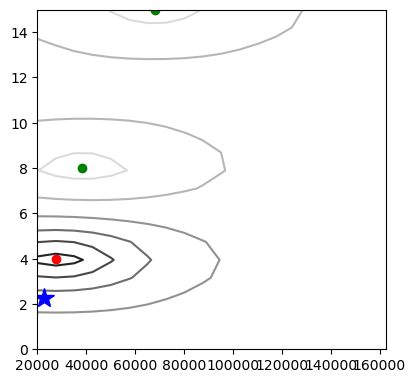

Optimization completed without errors
Would you rather $20000 today or $97848 in 2?


 1


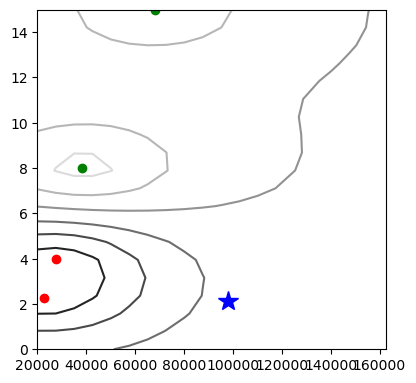

Optimization completed without errors
Would you rather $20000 today or $45073 in 0?


 1


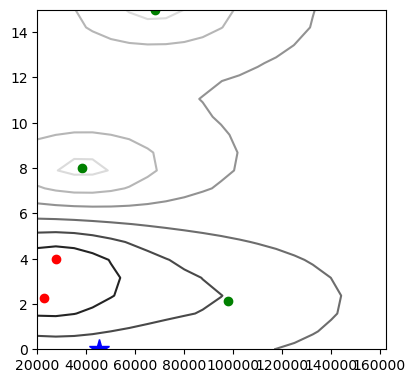

Optimization completed without errors
Would you rather $20000 today or $59944 in 4?


 1


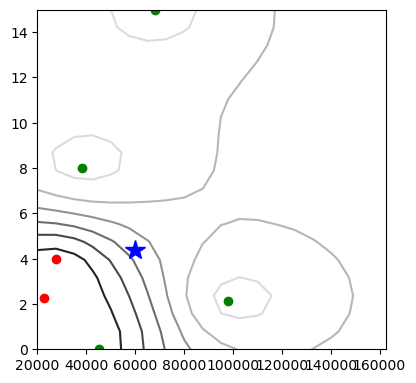

Optimization completed without errors
Would you rather $20000 today or $20751 in 5?


 0


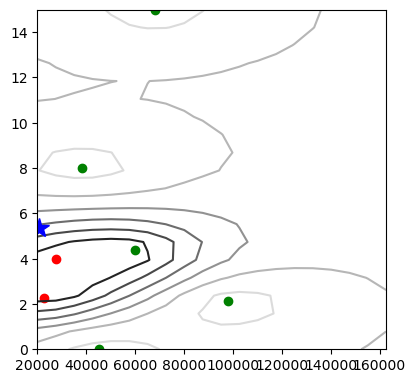

Optimization completed without errors
Would you rather $20000 today or $20264 in 0?


 0


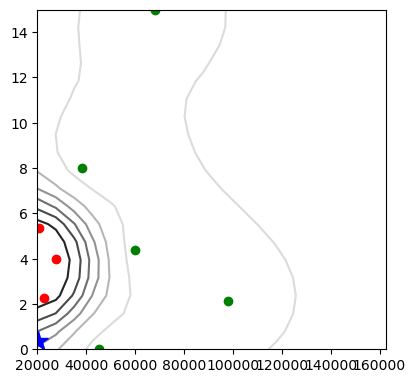

Optimization completed without errors
Would you rather $20000 today or $20110 in 8?


 0


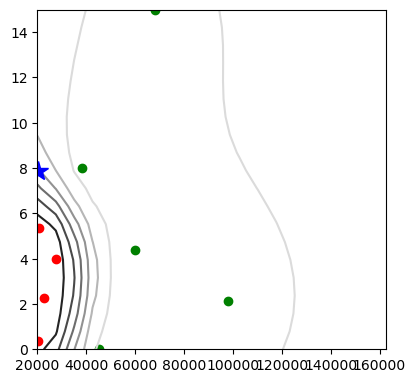

Optimization completed without errors
Would you rather $20000 today or $20141 in 14?


 0


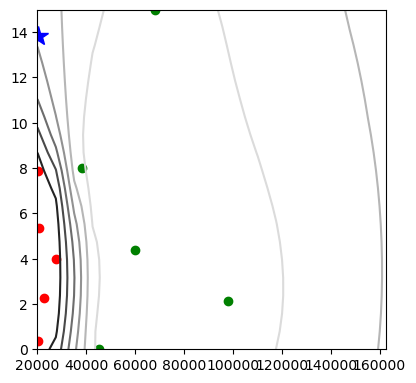

Optimization completed without errors
Would you rather $20000 today or $162698 in 15?


 1


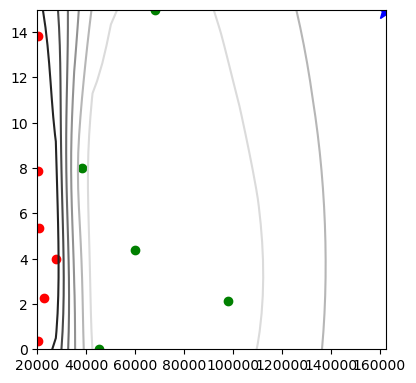

Optimization completed without errors
Would you rather $20000 today or $162688 in 0?


 1


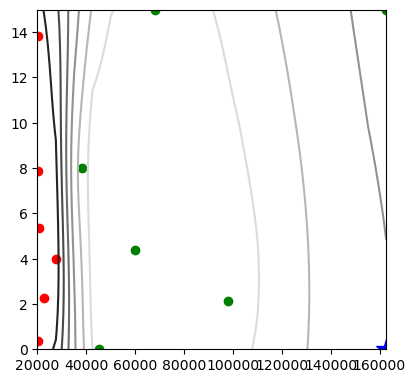

Optimization completed without errors
Would you rather $20000 today or $33943 in 15?


 0


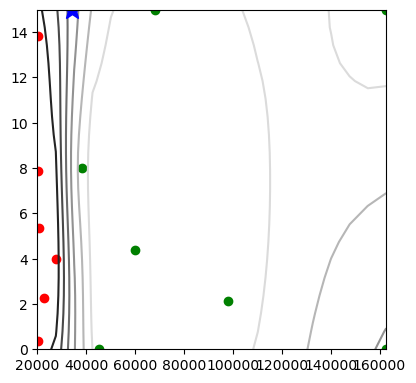

Optimization completed without errors
Would you rather $20000 today or $44365 in 15?


 0


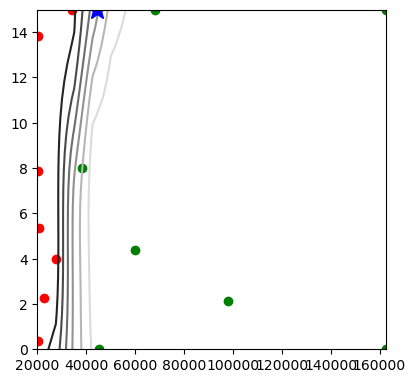

Optimization completed without errors
Would you rather $20000 today or $33435 in 0?


 1


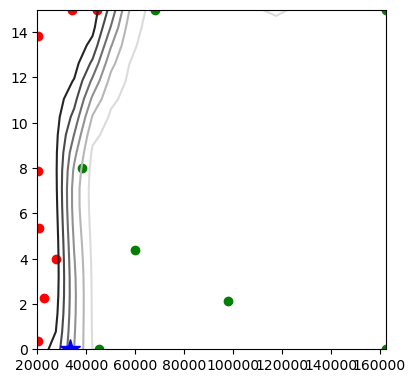

Optimization completed without errors
Would you rather $20000 today or $53457 in 15?


 0


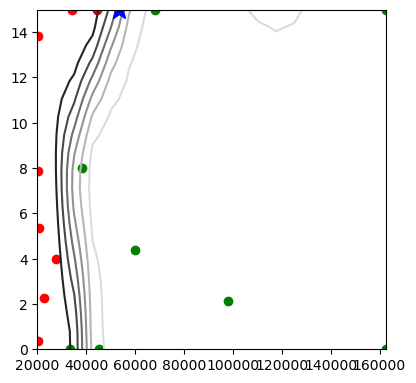

Optimization completed without errors
Would you rather $20000 today or $46819 in 12?


 0


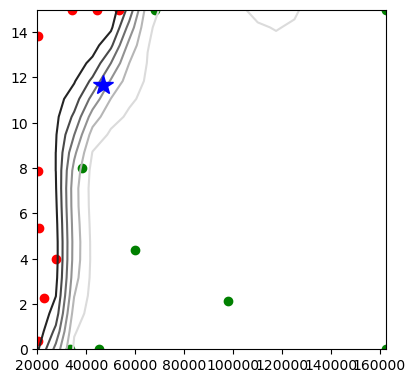

Optimization completed without errors
Would you rather $20000 today or $57211 in 12?


 1


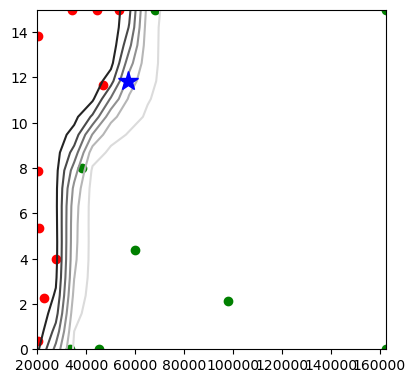

Optimization completed without errors
Would you rather $20000 today or $118794 in 15?


 1


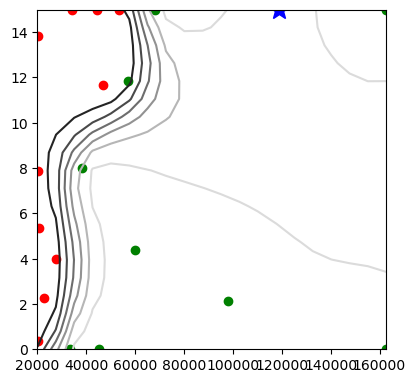

Optimization completed without errors
Would you rather $20000 today or $60512 in 15?


 1


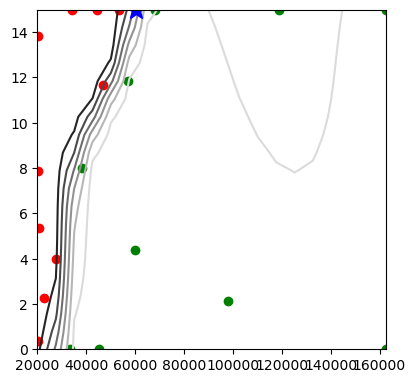

Optimization completed without errors
Would you rather $20000 today or $27388 in 0?


 1


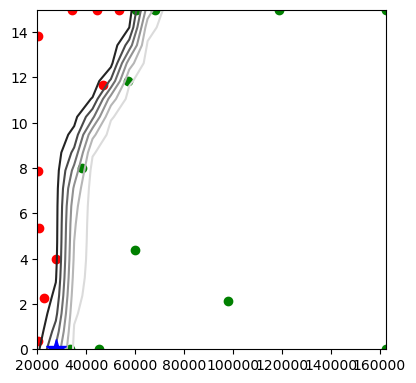

Optimization completed without errors
Would you rather $20000 today or $33102 in 4?


 0


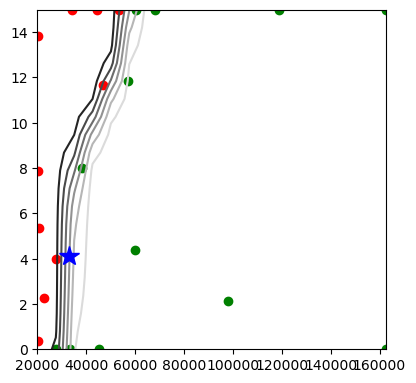

In [25]:
initial_data_set = X[:,:2]
observer = mk_observer(label)
search_space = trieste.space.Box([initialCapital, 0], [maximum, investmentHorizon])
# Grid data for later use
x_grid = np.linspace(initialCapital,maximum,20)
y_grid = np.linspace(0,investmentHorizon,20)
xx, yy = np.meshgrid(x_grid,y_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T
np.save('Xbig.npy', X)
intertemporalFunction, intertemporalData, b = train(X, observer, search_space, initial_data_set)

<AxesSubplot:>

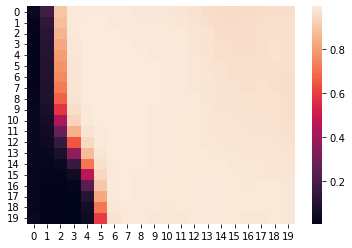

In [26]:
import seaborn as sns
sns.heatmap(intertemporalPredictions)

## Risk Preference PDF

We next get our probability distribution for risk preference utility.

Optimization completed without errors
Given 20000 today, could you bear $-12806 in 5?


 0


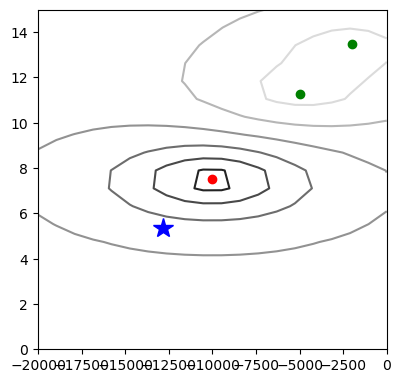

Optimization completed without errors
Given 20000 today, could you bear $-273 in 0?


 1


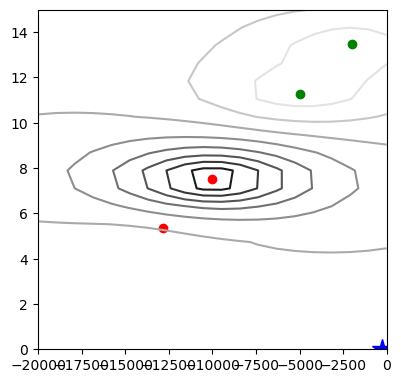

Optimization completed without errors
Given 20000 today, could you bear $-19577 in 8?


 0


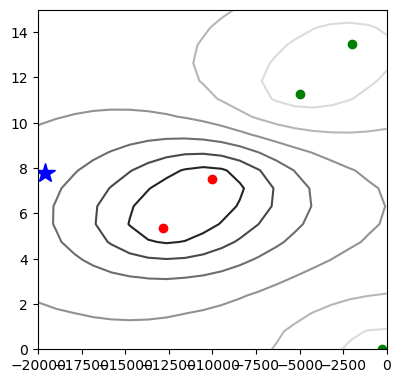

Optimization completed without errors
Given 20000 today, could you bear $-19973 in 1?


 0


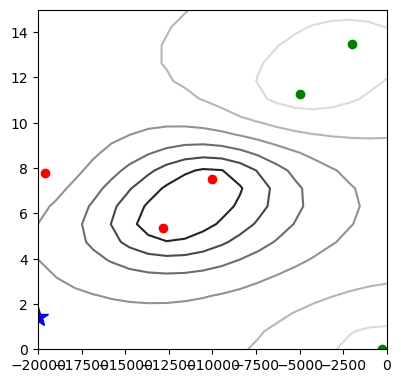

Optimization completed without errors
Given 20000 today, could you bear $-19343 in 15?


 0


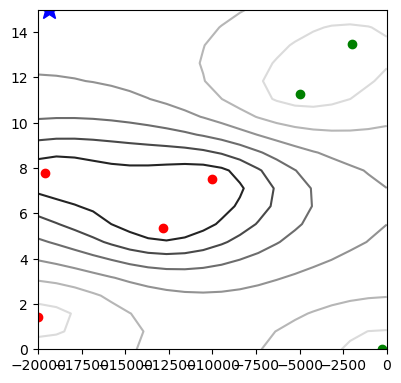

Optimization completed without errors
Given 20000 today, could you bear $-84 in 8?


 1


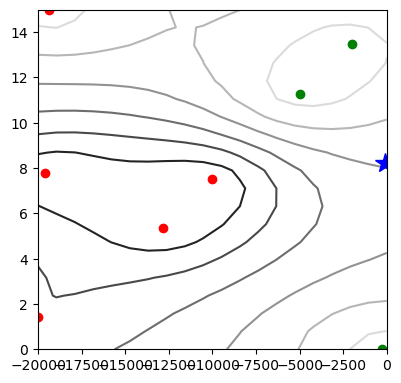

Optimization completed without errors
Given 20000 today, could you bear $-6788 in 0?


 0


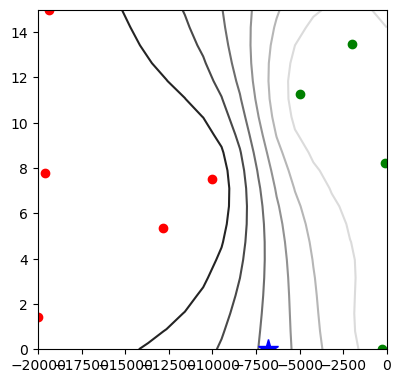

Optimization completed without errors
Given 20000 today, could you bear $-8626 in 15?


 1


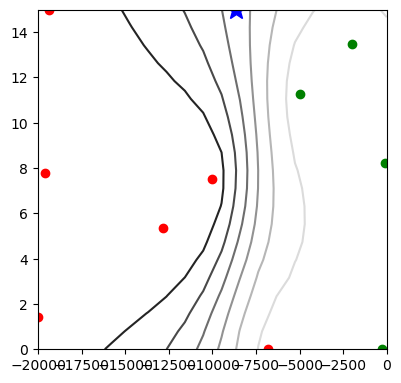

Optimization completed without errors
Given 20000 today, could you bear $-12470 in 15?


 0


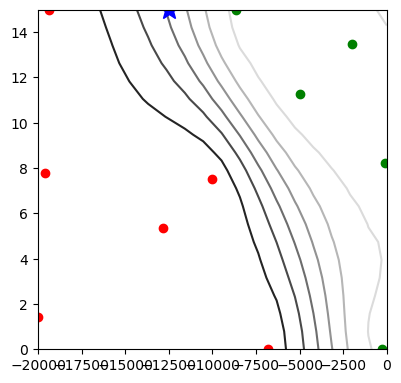

Optimization completed without errors
Given 20000 today, could you bear $-5264 in 5?


 1


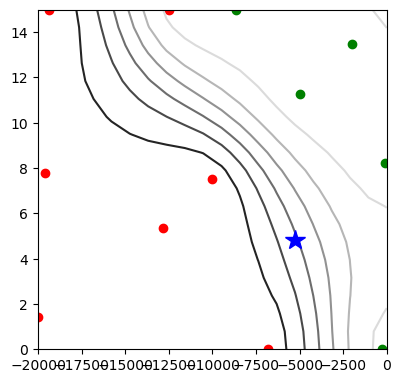

Optimization completed without errors
Given 20000 today, could you bear $-4739 in 0?


 1


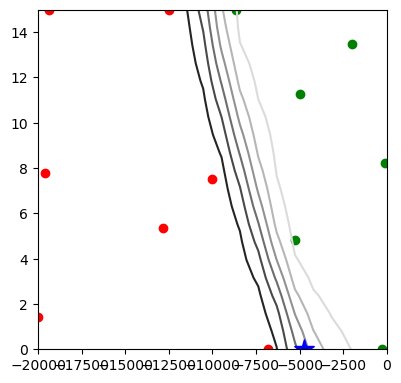

Optimization completed without errors
Given 20000 today, could you bear $-7877 in 8?


 1


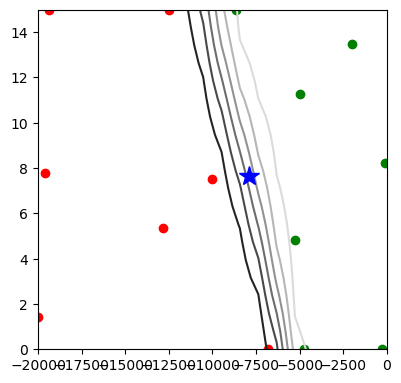

Optimization completed without errors
Given 20000 today, could you bear $-10300 in 15?


 1


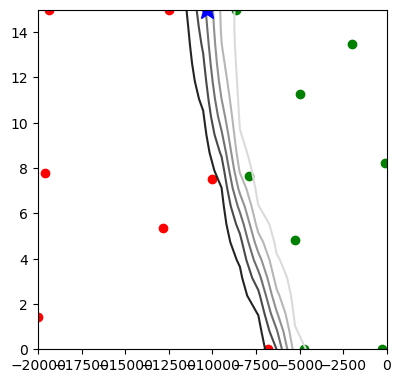

Optimization completed without errors
Given 20000 today, could you bear $-7472 in 4?


 1


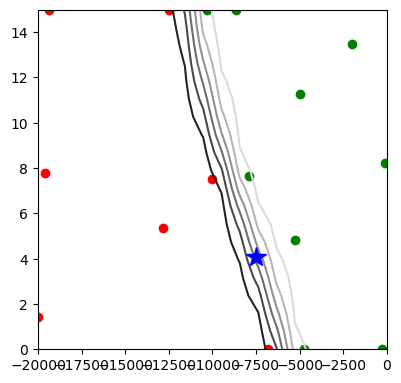

Optimization completed without errors
Given 20000 today, could you bear $-10237 in 11?


 1


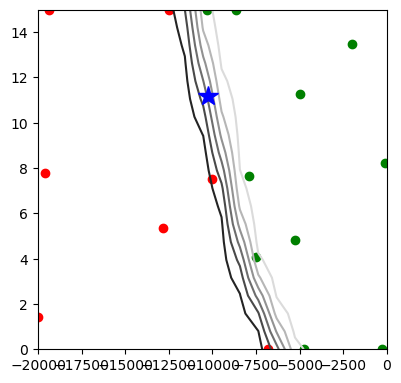

Optimization completed without errors
Given 20000 today, could you bear $-11474 in 15?


 1


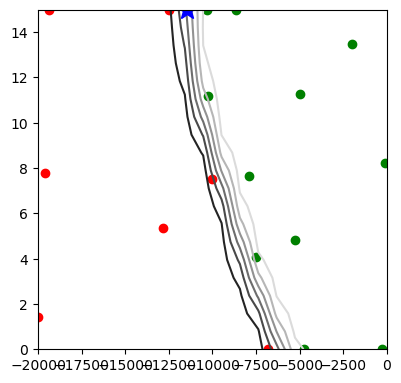

Optimization completed without errors
Given 20000 today, could you bear $-11364 in 11?


 1


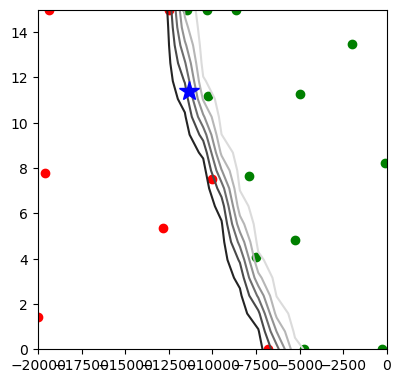

Optimization completed without errors
Given 20000 today, could you bear $0 in 15?


 0


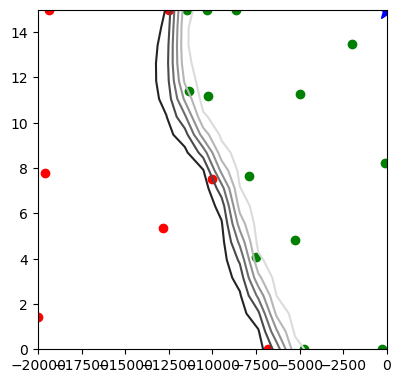

Optimization completed without errors
Given 20000 today, could you bear $0 in 13?


 0


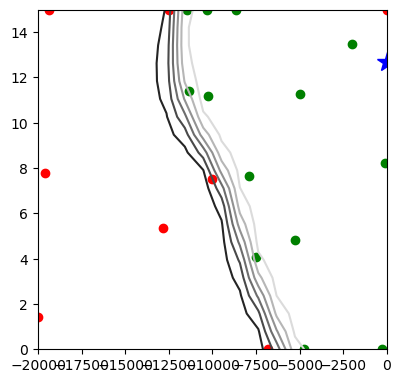

Optimization completed without errors
Given 20000 today, could you bear $-1751 in 15?


 1


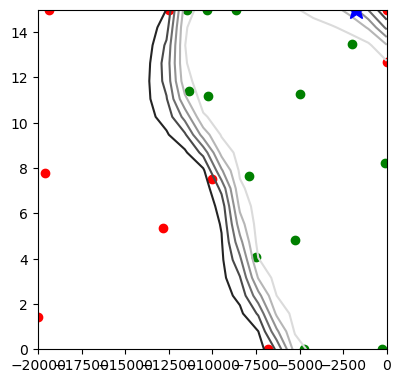

In [35]:
initial_data_set = X2[:,:2]
observer = mk_observer(label)
search_space = trieste.space.Box([-initialCapital, 0], [0, investmentHorizon])
# Grid data for later use
x_grid = np.linspace(-initialCapital,0,20)
y_grid = np.linspace(0,investmentHorizon,20)
xx, yy = np.meshgrid(x_grid,y_grid)
Xplot = np.vstack((xx.flatten(), yy.flatten())).T
np.save('Xbig.npy', X2)
trainString = f"Given {initialCapital} today, could you bear"
lims = {'xlim':[-initialCapital,0], 'ylim':[0,investmentHorizon]}
toleranceFunction, toleranceData, tolerancePredictions = train(X2, observer, search_space, initial_data_set, trainString, lims)

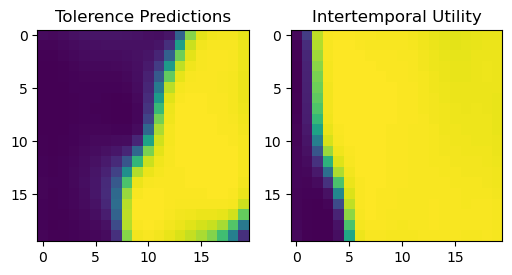

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100)

ax1.imshow(tolerancePredictions)
ax1.set_title('Tolerence Predictions')
ax2.imshow(intertemporalPredictions)
ax2.set_title('Intertemporal Utility')
plt.show()

## Modeling Index Funds and Matching with Intertemporal Preferences 

We have seen how we can develop probability distributions which model an individual's intertemporal preferences and their risk tolerance. Now we consider the returns of several index funds to see if a certain investor would be willing to accept them or not. Out of a library we can hopefully determined which is best suited and how much levarage could be used.

### Example S&P500

We use the S&P500 as a canoncial example of an index fund and whether a particular individual would find such a fund acceptable. We first load in the data.

In [57]:
import json
with open('../data/spReturns.json') as f:
    spList = json.load(f)

In [122]:
overlapLists = []
currentList = []
for i,ret in enumerate(spList):
    currentList.append(float(ret['totalReturn']))
    if i >= investmentHorizon:
        currentList = currentList[1:]
        if len(currentList) == investmentHorizon:
            overlapLists.append(currentList)

We can also play with the amount of levarage we have.

In [248]:
def historicalProperties(overlapLists,levarage):
    finalHappiness, finalAcceptance, belowTolerance, finalInvestment = [], [], [], []

    for timeSeries in overlapLists:
        currentCapital = initialCapital
        #print(timeseries)
        #print(currentCaptial)
        belowTol = 0
        currentCapitalList = []
        gainList = []
        for i, v in enumerate(timeSeries):
            prevCapital = currentCapital
            currentCapital = round(currentCapital * (1+levarage*v*0.01))
            if currentCapital < 0:
                currentCapital = 0
            currentCapitalList.append(currentCapital)
            #print(currentCapital)
            #print(v)
            gain = currentCapital-initialCapital
            gainList.append(gain)
            # if gain > 0:
            #     toleranceProb = 1
            # if toleranceProb < 0.5:
            #     belowTol = 1

        capitalArray = np.array(currentCapitalList)
        gainArray = np.array(gainList)
        delayArray = np.array(list(range(0,len(timeSeries))))
        combinedCapitalArray = np.expand_dims(np.vstack((capitalArray,delayArray)).T, axis=0)
        combinedGainArray = np.expand_dims(np.vstack((gainArray,delayArray)).T, axis=0)
        interTemporalProbs = intertemporalFunction._model.predict_y(combinedCapitalArray)[0].numpy()[0]
        toleranceProbs = toleranceFunction._model.predict_y(combinedGainArray)[0].numpy()[0]
            #print(f"With a current capital of {currentCaptial}, in this year they had a gain/loss compared to start of {gain} they are {round(interTemporalProb, 2)} happy and {round(toleranceProb, 2)} accepting")
        #print(f"Final hapiness {interTemporalProb}")
        #print(f"Final acceptance {toleranceProb}")
        #print(toleranceProbs)
        belowTol = False
        for i in range(0,len(gainArray)):
            if gainArray[i] < 0 and toleranceProbs[i] < 0.5:
                belowTol = True
        belowTolerance.append(belowTol)
        finalHappiness.append(interTemporalProbs[-1][0])
        finalInvestment.append(capitalArray[-1])
        finalAcceptance.append(toleranceProbs[-1][0])
    
    return finalHappiness, finalAcceptance, belowTolerance, finalInvestment

In [249]:
for levarage in [1,1.5,2,3]:
    finalHappiness, finalAcceptance, belowTolerance, finalInvestment = historicalProperties(overlapLists,levarage)

    print(f"### With a levarage of {100*levarage}% ###")
    print(f"Likeliness to be happy with investment: {100*round(sum(finalHappiness)/len(overlapLists),2)}%")
    print(f"Likeliness to cross risk threshold: {100*round(sum(belowTolerance)/len(overlapLists),2)}%")
    print(f"Average final return: {round(sum(finalInvestment)/len(overlapLists),2)}")
    print(f"Lowest final return: {round(min(finalInvestment),2)}")
    print(f"Highest final return: {round(max(finalInvestment),2)}")

### With a levarage of 100% ###
Likeliness to be happy with investment: 71.0%
Likeliness to cross risk threshold: 4.0%
Average final return: 117325.83
Lowest final return: 26369
Highest final return: 289720
### With a levarage of 150.0% ###
Likeliness to be happy with investment: 75.0%
Likeliness to cross risk threshold: 7.000000000000001%
Average final return: 259245.84
Lowest final return: 17637
Highest final return: 900896
### With a levarage of 200% ###
Likeliness to be happy with investment: 72.0%
Likeliness to cross risk threshold: 17.0%
Average final return: 548281.09
Lowest final return: 5462
Highest final return: 2534114
### With a levarage of 300% ###
Likeliness to be happy with investment: 59.0%
Likeliness to cross risk threshold: 47.0%
Average final return: 2211885.89
Lowest final return: 0
Highest final return: 15827739
